# Extracting support phrases for sentiment labels from Tweets

<img src="https://encrypted-tbn0.gstatic.com/images?q=tbn:ANd9GcTWUcN4geWf3-WTk1abNbOiBNMCugcc35QMfA&usqp=CAU" width="500px">

## Acknowledgements

This notebook could not have been possible without the help of my mentor [Anshul Sharma](https://www.kaggle.com/anshuls235) who guided me throughout the course of my learning journey, and the [Kaggle team](https://www.kaggle.com/kaggleteam) for providing me with an opportunity to explore this platform further and utilizing it fully for developing my skills.

Few notebooks which helped me in my work:
- [TensorFlow roBERTa - [0.705]](https://www.kaggle.com/cdeotte/tensorflow-roberta-0-705)
- [Tweet Sentiment RoBERTa PyTorch](https://www.kaggle.com/shoheiazuma/tweet-sentiment-roberta-pytorch)
- [roberta inference 5 folds](https://www.kaggle.com/abhishek/roberta-inference-5-folds)
- [BERT Base Uncased using PyTorch](https://www.kaggle.com/abhishek/bert-base-uncased-using-pytorch)

## Overview



This notebook is a PyTorch template for solving  Kaggle's Tweet Sentiment Extraction competition, using RoBERTa. All the steps are shown followed up with exaplanations and reasons for their usage. Starting with the question, `why is RoBERTa used?`


But before that, let me explain what BERT does....

### What is BERT?

BERT is a deep learning model that has given state-of-the-art results on a wide variety of natural language processing tasks. It is a multi-layer bidirectional Transformer encoder. And it has been pre-trained on Wikipedia and BooksCorpus and requires task-specific fine-tuning.


### What is the flow of information of a word in BERT?
A word starts with its embedding representation from the embedding layer. Every layer does some multi-headed attention computation on the word representation of the previous layer to create a new intermediate representation. All these intermediate representations are of the same size. In the figure above, E1 is the embedding representation, T1 is the final output and Trm are the intermediate representations of the same token. In a 12-layers BERT model a token will have 12 intermediate representations.

<img src="https://yashuseth.files.wordpress.com/2019/06/fig9.png" width="500px">

### What are the tasks BERT has been pre-trained on?
Masked Language Modeling and Next Sentence Prediction.

### What is Masked Language Modeling and why use it over standard language modeling?
Language Modeling is the task of predicting the next word given a sequence of words. In masked language modeling instead of predicting every next token, a percentage of input tokens is masked at random and only those masked tokens are predicted. Bi-directional models are more powerful than uni-directional language models. But in a multi-layered model bi-directional models do not work because the lower layers leak information and allow a token to see itself in later layers.

### What is Next Sentence Prediction?
Next sentence prediction task is a binary classification task in which, given a pair of sentences, it is predicted if the second sentence is the actual next sentence of the first sentence.



BERT’s key technical innovation makes it a popular attention model to language modelling. This is in contrast to previous efforts which looked at a text sequence either from left to right or combined left-to-right and right-to-left training.

### What makes RoBERTa different?

RoBERTa is an extension of BERT with changes to the pretraining procedure. The modifications include:

- training the model longer, with bigger batches, over more data
- removing the next sentence prediction objective
- training on longer sequences
- dynamically changing the masking pattern applied to the training data


<img src="https://paperswithcode.com/media/methods/Screen_Shot_2020-05-31_at_1.41.28_PM.png" width="500px">


## Importing libraries, loading the data and the tokenizer

For this notebook, [HuggingFace](https://huggingface.co/transformers/model_doc/roberta.html) transformers are used.

### Importing libraries

In [1]:
import torch
import pandas as pd
import numpy as np
import re
import random

import torch.nn as nn                     # neural networks
import torch.nn.functional as F           # layers, activations and more
import torch.optim as optim               # optimizers e.g. gradient descent, ADAM, etc.
from torch.optim import lr_scheduler

from tqdm.autonotebook import tqdm

#nltk
from nltk.corpus import stopwords
stop=set(stopwords.words('english'))
import string

#!pip install git+https://github.com/gmihaila/ml_things
#from ml_things import plot_dict

from sklearn import model_selection
from sklearn.model_selection import StratifiedKFold
import transformers
import tokenizers
from transformers import AdamW
from transformers import get_linear_schedule_with_warmup
from tokenizers import ByteLevelBPETokenizer
from transformers import RobertaModel, RobertaConfig
from torch.utils.data import Dataset, DataLoader

from transformers import logging
logging.set_verbosity_warning()
import warnings
warnings.filterwarnings('ignore')

%matplotlib inline
import matplotlib.pyplot as plt

### Loading data

In [2]:
train_df = pd.read_csv('../input/tweet-sentiment-extraction/train.csv')
train_df.drop(314, inplace=True) # This row was found to have 'nan' values, so dropping it
train_df.reset_index(drop=True, inplace=True)
train_df['text'] = train_df['text'].astype(str)
train_df['selected_text'] = train_df['selected_text']

test_df = pd.read_csv('../input/tweet-sentiment-extraction/test.csv').reset_index(drop=True)
test_df['text'] = test_df['text'].astype(str)

Check to see if there are any null values in the dataset. 

In [3]:
pd.isnull(train_df.selected_text).sum()
train_df.loc[pd.isnull(train_df.selected_text),:]

,textID,text,selected_text,sentiment


Checking the class (or sentiment) imbalance in the data

Text(0.5, 0, 'Sentiment balance in the data')

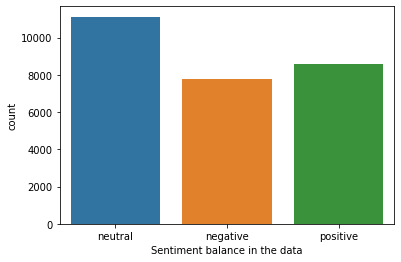

In [4]:
import seaborn as sns
ax = sns.countplot(train_df.sentiment)
plt.xlabel('Sentiment balance in the data')

### Loading tokenizer
The transformers library provides a wide variety of transformer models (including roBERta), which work on PyTorch (or TensorFlow). And it even includes prebuild tokenizers which do the heavy lifting for us.

RoBERTa uses a variant called " byte-level BPE ", the main benefit it gives is that it results in a smaller vocabulary while maintaining the quality of splits. The tokenizer used here is byte-level BPE (BBPE), since it is compacter than character vocabulary and has no out-of-vocabulary tokens, and also more efficient than using pure bytes only. Studies show that BBPE has comparable performance to BPE while its size is only 1/8 of that for BPE. With the same vocabulary size, BBPE segments sentences into shorter sequences than character-based methods do, leading to faster training and inference. Also it has some additional convenience features like `lowercase=True` and `addprefixspace=True`.

**Want to know more about BPE?** <br>
BPE is a frequency-based character concatenating algorithm: it starts with two-byte characters as tokens and based on the frequency of n-gram token-pairs, it includes additional, longer tokens. For example, if the letter `e` and `r` are frequently together in the language, a new token, `er` is added to the vocabulary. Next, if `h` and `er` are frequently together, `her` is added to the vocabulary. The algorithm goes on until it reaches the wanted size.
The word _tokenization_ tokenized with the model RoBERTa:
`[‘token’, ‘ization’]`

**NOTE:** If we compare it with 'bert-based-cased' model, the word _tokenization_ will be tokenized as `[‘token’, ‘##ization’]`

In [5]:
PATH = "../input/roberta-base"

tokenizer = ByteLevelBPETokenizer(
            vocab = f'{PATH}/vocab.json', 
            merges= f'{PATH}/merges.txt', 
            add_prefix_space = True,
            lowercase=True)

tokenizer.enable_truncation(max_length=512)    # since length cannot be set, use enable_truncation() instead

Setting some configurations for the model:

In [6]:
MAX_LENGTH = 100
TRAIN_BATCH_SIZE = 32
TEST_BATCH_SIZE = 16
EPOCHS = 10

In [7]:
device = torch.device("cuda:0" if torch.cuda.is_available() else "cpu")

## Token ids for a few common tokens

### Checking for the sentiment ids in the tokenizer

In [8]:
val1 = tokenizer.encode('negative').ids
val2 = tokenizer.encode('positive').ids
val3 = tokenizer.encode('neutral').ids
val1, val2, val3

([2430], [1313], [7974])

### The special tokens which are used in the sentences

- ('[SEP]', 102) <br>   `[SEP]` - marker for ending of a sentence
- ('[CLS]', 101) <br>   `[CLS]` - we must add this token to the start of each sentence, so BERT knows we're doing classification
- ('[PAD]', 0) <br>   special token for padding

## Preprocessing
Since machine learning models do not work with raw text, these texts are needed to be converted to numbers (of some sort). BERT (or roBERTa) requires more attention:
- Add special tokens to separate sequences and do the classification ([CLS], [SEP])
- Passing sequences of constant length (by introducing padding)
- Creating array of 0s (pad token) and 1s (real token) called _attention mask_


The texts are tokenized using a byte version of Byte-Pair Encoding (BPE) and a vocabulary size of 50,000. The inputs of the model take pieces of 512 contiguous token that may span over documents. The beginning of a new document is marked with [CLS] and the end of one by [SEP].

The details of the masking procedure for each sentence are the following:

- 15% of the tokens are masked.
- In 80% of the cases, the masked tokens are replaced by <mask>.
- In 10% of the cases, the masked tokens are replaced by a random token (different) from the one they replace.
- In the 10% remaining cases, the masked tokens are left as is.

    
 Contrary to BERT, the masking is done dynamically during pretraining (e.g., it changes at each epoch and is not fixed).
    
Both the train and text are tokenized in the same way, just creating some additional conditions for the training set.

PyTorch allows us to create custom datasets and implement data loaders upon then. This makes programming in PyTorch very flexible.

Dataset – It is mandatory for a DataLoader class to be constructed with a dataset first. PyTorch Dataloaders support two kinds of datasets:
- Map-style datasets – These datasets map keys to data samples. Each item is retrieved by a __ __get_item__()__ method implementation.
- Iterable-style datasets – These datasets implement the __ __iter__()__ protocol. Such datasets retrieve data in a stream sequence rather than doing random reads as in the case of map datasets.

Here, the map-style datasets is used.

The following is a Custom dataset which consists of 3 main classes:

- __ __init__()__: Constructor function. Deals with class instance initalization, variable definition, etc
- __ __getitem__()__: This function deals with getting the elements when the dataset is called in iteration
- __ __len__()__: Length function overload. This function just returns the length of the dataset.

To define the custom dataset, we need to override two major functions of the torch.util.data.Dataset class – __ __len__ __ and __ __getitem__ __ – which are used to retrieve the size of the dataset and get a sample item from a particular index respectively.

In [9]:
class TextDataset(Dataset):
    
    def __init__(self, df, tokenizer, max_length):
        #data loading
        self.df = df
        self.selected_text = "selected_text" in df
        self.tokenizer = tokenizer
        self.max_length = MAX_LENGTH
        
    def __len__(self):
        #len(dataset) i.e., the total number of samples
        return len(self.df)
    
    '''
    def cleanText(self, text):
        #clean the text
        text = str(text).lower()
        text = re.sub('\[.*?\]', '', text)
        text = ' '.join([word for word in text.split(' ') if word not in stop])
        text = text.encode('ascii', 'ignore').decode()
        text = re.sub(r'https*\S+', ' ', text)
        text = re.sub(r'@\S+', ' ', text)
        text = re.sub(r'#\S+', ' ', text)
        text = re.sub(r'\'\w+', '', text)
        text = re.sub('[%s]' % re.escape(string.punctuation), ' ', text)
        text = re.sub(r'\w*\d+\w*', '', text)
        text = re.sub(r'\s{2,}', ' ', text)
        text = re.sub(r"^\s+|\s+$", "", text) 
        #text = re.sub(r'[^a-zA-Z\']', ' ', text)
        #text = re.sub(r'[^\x00-\x7F]+', '', text)
        return text
    '''

    
    def get_data(self, row):
        #processing the data
        text = " "+" ".join(row.text.lower().split()) # clean the text
        encoded_input = self.tokenizer.encode(text) # the sentence to be encoded
        
        sentiment_id = {
                'positive': 1313,
                'negative': 2430,
                'neutral': 7974
            }  # stating the ids of the sentiment values 
        
        #print ([list((i, encoded_input[i])) for i in range(len(encoded_input))])
        '''
        # The input_ids are the sentence or sentences represented as tokens. 
        # There are a few BERT special tokens that one needs to take note of:

        # [CLS] - Classifier token, value: [101] 
        # [SEP] - Separator token, value: [102]
        # [PAD] - Padding token, value: 0

        # Bert expects every row in the input_ids to have the special tokens included as follows:

        # For one sentence as input:
        # [CLS] ...word tokens... [SEP]

        # For two sentences as input:
        # [CLS] ...sentence1 tokens... [SEP]..sentence2 tokens... [SEP]
        '''
        
        input_ids = [101] + [sentiment_id[row.sentiment]] + [102] + encoded_input.ids + [102]
            
        '''
        id: unique identifier for each token
        offset: starting and ending point in a sentence
        '''        
                 
        #ID offsets       
        offsets = [(0, 0)] * 3 + encoded_input.offsets + [(0, 0)]     # since first 3 are [CLS] ...sentiment tokens... [SEP]
        
        
        pad_len = self.max_length - len(input_ids)    
        if pad_len > 0:
            input_ids += ([0] * pad_len)
            offsets += ([(0, 0)] * pad_len)
                       
        input_ids = torch.tensor(input_ids, dtype=torch.long)
        
        # The mask has 1 for real tokens and 0 for padding tokens. Only real tokens are attended to.
        masks = torch.where(input_ids != 0, torch.tensor(1), torch.tensor(0))  
        '''
        # The attention mask has the same length as the input_ids(or token_type_ids). 
        # It tells the model which tokens in the input_ids are words and which are padding. 
        # 1 indicates a word (or special token) and 0 indicates padding.

        # For example:
        # Tokens: [101, 7592, 2045, 1012,  102,    0,    0,    0,    0,    0]
        # Attention mask: [1, 1, 1, 1, 1, 0, 0, 0, 0, 0]
        '''
        
        masks = torch.tensor(masks, dtype=torch.long)
        offsets = torch.tensor(offsets, dtype=torch.long)
                
        return input_ids, masks, text, offsets
    
    def get_target_ids(self, row, text, offsets):
        # preparing data only for the training
        selected_text = " " + " ".join(row.selected_text.lower().split())

        string_len = len(selected_text) - 1
        
        idx0 = None
        idx1 = None
            
        for ind in (position for position, line in enumerate(text) if line == selected_text[1]):
            if " " + text[ind: ind+string_len] == selected_text:
                idx0 = ind
                idx1 = ind + string_len - 1
                break
                
        char_targets = [0] * len(text)
        if idx0 != None and idx1 != None:
            for ct in range(idx0, idx1 + 1):
                char_targets[ct] = 1
        '''
        char_targets only give 1 to the part of the selected_text within a text
        e.g: [0. 0. 0. 0. 0. 0. 0. 1. 1. 1. 1. 1. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0. 0.]
        Here, for the length of the text, [1] is only at the index position of the selected text.
        This helps us get the start and end indices of the selected text in the next stage.
        '''               
        # Start and end tokens
        target_idx = []
        for k, (offset1, offset2) in enumerate(offsets):
            if sum(char_targets[offset1: offset2]) > 0:
                try:
                    target_idx.append(k)
                except:
                    continue

        targets_start = target_idx[0]
        targets_end = target_idx[-1]
                
        return selected_text, targets_start, targets_end
    
   
    
    def __getitem__(self, index): # addressing each row by its index
        #dataset[index] i.e., generates one sample of data
        data = {}
        row = self.df.iloc[index]
        
        ids, masks, text, offsets = self.get_data(row)
        data['ids'] = ids
        data['masks'] = masks
        data['text'] = text
        data['offsets'] = offsets
        data['sentiment'] = row.sentiment
        
        if self.selected_text:   #checking if selected text exists
            # This part only exists in the training
            selected_text,start_index, end_index = self.get_target_ids(row, text, offsets)
            data['start_index'] = start_index
            data['end_index'] = end_index   
            data['selected_text'] = selected_text
                
        return data


As you can see from the above, the function for clean text is commented out. This is because BERT uses the BPE based technique for tokenization. And in this approach an out of vocabulary word is progressively split into subwords and the word is then represented by a group of subwords. Since the subwords are part of the vocabulary, we have learned representations an context for these subwords and the context of the word is simply the combination of the context of the subwords.


Although stop words lack lexical content, they are not entirely devoid of content. Since stop words contribute meaning, and because BERT is sensitive to such meanings, stop words need not be eliminated.

Observe the data dictionary generated through the TextDataset class

In [10]:
e = TextDataset(train_df, tokenizer, MAX_LENGTH)
e[1]

{'ids': tensor([  101,  2430,   102,    98,  3036,  5074,   939,    40,  2649,    47,
           259,    11, 15610,  1597,  2977, 16506,   102,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0,
             0,     0,     0,     0,     0,     0,     0,     0,     0,     0]),
 'masks': tensor([1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 1, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0,
         0, 0, 0, 0, 0, 0, 0, 

## Build the RoBERTa model architecture

A pretrained roBERTa base model is used with a custom question answer head, where the tweet text takes the role of the 'question', and the selected text takes the role of an 'answer'. It follows the pattern:
<br>text, selected_text = "what interview! leave me alone", "leave me alone"
<br>input_text = "[CLS] " + text + " [SEP] " + selected_text + " [SEP]"

There are a lot of helpers that make using BERT easy with the Transformers library. Depending on the task, one might want to use BertForSequenceClassification, BertForQuestionAnswering or something else. Instead, for this model, the basic RobertaModel is used to build the classifer on top of that.

In [11]:
class TextModel(nn.Module):
     
    def __init__(self):
        super(TextModel, self).__init__()
        # RoBERTa encoder 
        config = RobertaConfig.from_pretrained(
            '../input/roberta-base/config.json', output_hidden_states=True)    
        self.roberta = RobertaModel.from_pretrained(
            '../input/roberta-base/pytorch_model.bin', config=config)

        for param in self.roberta.parameters():
            param.requires_grad = True
    
        self.drop0 = nn.Dropout(0.15)
        self.l0 = nn.Linear(config.hidden_size * 2,config.hidden_size) 
        # Multiplied by 2 since the forward pass concatenates the last two hidden representation layers
        self.drop1 = nn.Dropout(config.hidden_dropout_prob)
        self.l1 = nn.Linear(config.hidden_size, 2)  # The output will have two dimensions- start and end logits
        torch.nn.init.normal_(self.l0.weight, std=0.02)
        torch.nn.init.normal_(self.l0.bias, 0)
        
    def forward(self, ids, masks): #, token_type_ids
        # Return the hidden states from the RoBERTa backbone
        # Type: torch tensor
        last_hidden_state, pooled_output, hidden_states = self.roberta(input_ids=ids, attention_mask=masks, return_dict=False)
        # input_ids.shape and attention_mask.shape both will be of the size (batch size x seq length)
        #print(last_hidden_state.shape) : torch.Size([24, 100, 768])
        # But why 768? 
        #This is the number of hidden units in the feedforward-networks. We can verify that by checking the config.
        '''
        About the parameters:
        
        input_ids (torch.LongTensor of shape (batch_size, sequence_length)) –
        Indices of input sequence tokens in the vocabulary.
        Indices can be obtained using Tokenizer. See transformers.PreTrainedTokenizer.encode() and transformers.PreTrainedTokenizer.__call__() for details.

        attention_mask (torch.FloatTensor of shape (batch_size, sequence_length), optional) –
        Mask to avoid performing attention on padding token indices. Mask values selected in [0, 1]:
        1 for tokens that are not masked,
        0 for tokens that are masked.
        
        '''
        
        # Concatenate the last two hidden states
        out = torch.cat((hidden_states[-1], hidden_states[-2]), dim=-1)   
        #out = torch.mean(out, 0) # take the mean along axis 0
        
        # adding dropouts and linear layers
        out = self.drop0(out)
        out = F.relu(self.l0(out))
        out = self.drop1(out) 
        out = self.l1(out) 
        
        #splitting the tensor into two logits 
        start_logits, end_logits = out.split(1, dim=-1) # dimension along which to split the tensor.
        # Return a tensor with all the dimensions of input of size 1 removed, for both the logits.
        start_logits = start_logits.squeeze()  #Squeezing a tensor removes the dimensions or axes that have a length of one
        end_logits = end_logits.squeeze() 
        
        return start_logits, end_logits        

The classifier delegates most of the heavy lifting to the RobertaModel. The dropout layers are used for some regularization and fully-connected layers for our output. Note that the raw output of the last layer is returned (or used in this case) since that is required for the cross-entropy loss function in PyTorch to work.

## Dataloaders

DataLoader combines a dataset and a sampler, and provides an iterable over the given dataset. Using the DataLoader class improves both the accuracy and the loss for the model.

The DataLoader class, in addition to the Dataset class (as discussed earlier), takes in the following important arguments:

- batch_size, which denotes the number of samples contained in each generated batch.

- shuffle. If set to True, we will get a new order of exploration at each pass (or just keep a linear exploration scheme otherwise). Shuffling the order in which examples are fed to the classifier is helpful so that batches between epochs do not look alike. Doing so will eventually make our model more robust.

- num_workers, which denotes the number of processes that generate batches in parallel. A high enough number of workers assures that CPU computations are efficiently managed, i.e. that the bottleneck is indeed the neural network's forward and backward operations on the GPU (and not data generation).

### Training and validation dataloaders

In [12]:
def train_val_dataloaders(df, train_idx, val_idx, batch_size):
    train_df = df.iloc[train_idx]
    val_df = df.iloc[val_idx]

    train_loader = torch.utils.data.DataLoader(
        TextDataset(train_df, tokenizer, MAX_LENGTH), 
        batch_size=batch_size, 
        shuffle=True, 
        num_workers=0,   # to avoid multi-process, keep it at 0
        drop_last=True)

    val_loader = torch.utils.data.DataLoader(
        TextDataset(val_df, tokenizer, MAX_LENGTH),
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)

    dataloaders_dict = {"train": train_loader, "val": val_loader}

    return dataloaders_dict

### Test dataloader

In [13]:
def test_loader(df, batch_size=TEST_BATCH_SIZE):
    loader = torch.utils.data.DataLoader(
        TextDataset(test_df, tokenizer, MAX_LENGTH), 
        batch_size=batch_size, 
        shuffle=False, 
        num_workers=0)    
    return loader

## Functions for evaluation

### Loss Function
Cross-entropy is the default loss function to use for multi-class classification problems. In here, it will return the sum of the cross entropy losses for both the start and end logits. It is the preferred loss function under the inference framework of maximum likelihood, and is usually evaluated first.  

In [14]:
def loss_function(start_logits, end_logits, start_positions, end_positions):
    # calculating cross entropy losses for both the start and end logits
    loss = nn.CrossEntropyLoss(reduction='mean') # for a multi-class classification problem
    start_loss = loss(start_logits, start_positions)
    end_loss = loss(end_logits, end_positions)
    total_loss = (start_loss + end_loss)
    return total_loss

### Function to predict the selected text using the logit values we get from the model

In [15]:
def get_selected_text(text, start_idx, end_idx, offsets):
    if end_idx < start_idx:
        end_idx = start_idx
    select_text = ""
    for idx in range(start_idx, end_idx + 1):
        select_text += text[offsets[idx][0]: offsets[idx][1]]
        if (idx + 1) < len(offsets) and offsets[idx][1] < offsets[idx + 1][0]:
            select_text += " "
    return select_text

### Evaluation metric
Jaccard Similarity is also known as the Jaccard index and Intersection over Union. Jaccard Similarity matric used to determine the similarity between two text document means how the two text documents close to each other in terms of their context that is how many common words are exist over total words. 


For this dataset, it is essential to use this metric for getting a similarity score between the text and the selected text of the train dataset, which we can further use for making predictions of the selected text for the test text data.

In [16]:
# evaluation metric 
def jaccard(str1, str2): 
    a = set(str1.lower().split()) 
    b = set(str2.lower().split())
    c = a.intersection(b)
    d = (len(a) + len(b) - len(c))
    if d != 0:
         return float(len(c) / d)
    else:
         return 0.0

### Calculating jaccard similarity score
Using the above functions, find the similarity score between the predicted selected text and the actual text.

In [17]:
def find_jaccard_score(text, selected_text, sentiment, offsets, start_logits, end_logits): #start_idx, end_idx
    start_pred = np.argmax(start_logits) # Predicted start index using argmax
    end_pred = np.argmax(end_logits) # Predicted end index using argmax
    if (end_pred <= start_pred) or sentiment == 'neutral' or len(text.split()) < 2:
        enc = tokenizer.encode(text)
        prediction = tokenizer.decode(enc.ids[start_pred-1:end_pred])   
    else:
        prediction = get_selected_text(text, start_pred, end_pred, offsets)
    true = selected_text
    #true = get_selected_text(text, start_idx, end_idx, offsets)
    return jaccard(true, prediction), prediction

## Training the model



In [18]:
train_loss = []
val_loss = []
jac_train = []
jac_val = []

In [19]:
def train(model, dataloaders_dict, optimizer, num_epochs, scheduler, device, filename): 
    '''
    Train pytorch model on a single pass through the data loader.
 
        This function is built with reusability in mind: it can be used as is as long
        as the `dataloader` outputs a batch in dictionary format that can be passed 
        straight into the model - `model(**batch)`.

      Some of the arguments:

      dataloader (:obj:`torch.utils.data.dataloader.DataLoader`):
          Parsed data into batches of tensors.
 
      optimizer_ (:obj:`transformers.optimization.AdamW`):
          Optimizer used for training.
 
      scheduler_ (:obj:`torch.optim.lr_scheduler.LambdaLR`):
          PyTorch scheduler.
 
      device_ (:obj:`torch.device`):
          Device used to load tensors before feeding to model.
    '''
    # Set device as `cuda` (GPU)
    model.to(device)
    
    for epoch in range(num_epochs):
        for key in ['train', 'val']:
            if key == 'train':
                model.train()
                dataloaders = dataloaders_dict['train']
            else:
                model.eval()
                dataloaders = dataloaders_dict['val']

            epoch_loss = 0.0
            epoch_jaccard = 0.0
            
            # Set tqdm to add loading screen and set the length
            loader = tqdm(dataloaders, total=len(dataloaders))
            #print(len(dataloaders))
                        
            # loop over the data iterator, and feed the inputs to the network
            # Train the model on each batch
            for (idx, data) in enumerate(loader):
                ids = data['ids']
                masks = data['masks']
                text = data['text']
                offsets = data['offsets'].numpy()
                start_idx = data['start_index']
                end_idx = data['end_index']
                sentiment = data['sentiment']

                model.zero_grad()
                optimizer.zero_grad()
                
                ids = ids.to(device, dtype=torch.long)
                masks = masks.to(device, dtype=torch.long)
                start_idx = start_idx.to(device, dtype=torch.long)
                end_idx = end_idx.to(device, dtype=torch.long)

                with torch.set_grad_enabled(key == 'train'): 

                    start_logits, end_logits = model(ids, masks) 
                    
                    loss = loss_function(start_logits, end_logits, start_idx, end_idx)
                    
                    if key == 'train':
                        if idx != 0: 
                            loss.backward() # Perform a backward pass to calculate the gradients
                        optimizer.step() # Update parameters and take a step using the computed gradient
                        scheduler.step() # Update learning rate schedule                        
                        
                        # Clip the norm of the gradients to 1.0.
                        # This is to help prevent the "exploding gradients" problem.
                        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)  
                        
                    epoch_loss += loss.item() * len(ids)
                    
                    # Move logits to CPU
                    # detaching these outputs so that the backward passes stop at this point
                    start_idx = start_idx.cpu().detach().numpy()
                    end_idx = end_idx.cpu().detach().numpy()
                    start_logits = torch.softmax(start_logits, dim=1).cpu().detach().numpy()
                    end_logits = torch.softmax(end_logits, dim=1).cpu().detach().numpy()
                    
                    selected_text = data['selected_text']
                    
                    filtered_sentences = []
                    for i, t_data in enumerate(text):
                    #for i in range(len(ids)):                        
                        jaccard_score, filtered_output = find_jaccard_score(
                            t_data,
                            selected_text[i],
                            sentiment[i],
                            offsets[i],
                            start_logits[i], 
                            end_logits[i])
                        epoch_jaccard += jaccard_score
                        filtered_sentences.append(filtered_output)
            
            # Calculate the average loss over the training data
            epoch_loss = epoch_loss / len(dataloaders.dataset)
            # Calculate the average jaccard score over the training data
            epoch_jaccard = epoch_jaccard / len(dataloaders.dataset)
            
            print('Epoch {}/{} | {:^5} | Loss: {:.4f} | Jaccard: {:.4f}'.format(
                epoch + 1, num_epochs, key, epoch_loss, epoch_jaccard))
            
            # Store the loss value for plotting the learning curve.
            if key == 'train':
                train_loss.append(epoch_loss)
                jac_train.append(epoch_jaccard)
                
            else:
                val_loss.append(epoch_loss)
                jac_val.append(epoch_jaccard)
    
    torch.save(model.state_dict(), filename)

A random seed is used to ensure that results of our model are reproducible. In other words, the use of this parameter ensures that anyone who runs your code will get the exact same outputs. In data science reproducibility is extremely important.

In [20]:
def set_seed(seed):
    # Set random seed for reproducibility
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)
        torch.backends.cudnn.deterministic = True
        torch.backends.cudnn.benchmark = True
        
seed = 777
set_seed(seed)

In stratified k-fold cross-validation, the folds are selected so that the mean response value is approximately equal in all the folds. For preserving the imbalanced class distribution in each fold, it is used here.

In [21]:
skf = StratifiedKFold(n_splits=3,shuffle=True,random_state=seed)

In [22]:
%%time

for fold, (idxTrain, idxVal) in enumerate(skf.split(train_df, train_df.sentiment), start=1):
    
    print('#'*10)
    print('### FOLD %i'%(fold))
    print('#'*10)
    
    model = TextModel()
    optimizer = AdamW(model.parameters(), lr=3e-5, weight_decay=0.01, correct_bias=False)
    dataloaders_dict = train_val_dataloaders(train_df, idxTrain, idxVal, batch_size=TRAIN_BATCH_SIZE)
    num_training_steps = int(len(train_df) / EPOCHS * TRAIN_BATCH_SIZE)
    # warmup_proportion = float(num_warmup_steps) / float(num_training_steps)
    scheduler = get_linear_schedule_with_warmup(
                  optimizer,
                  num_warmup_steps=0, #default #use a linear scheduler with no warmup steps
                  num_training_steps=num_training_steps
                )    
    train(
        model, 
        dataloaders_dict, 
        optimizer, 
        EPOCHS,
        scheduler,
        device,
        f'bert_fold{fold}.pth')

##########
### FOLD 1
##########


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 1/10 | train | Loss: 2.0966 | Jaccard: 0.4926


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 1/10 |  val  | Loss: 1.6758 | Jaccard: 0.5175


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 2/10 | train | Loss: 1.6219 | Jaccard: 0.5167


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 2/10 |  val  | Loss: 1.6949 | Jaccard: 0.5023


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 3/10 | train | Loss: 1.4428 | Jaccard: 0.5303


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 3/10 |  val  | Loss: 1.6854 | Jaccard: 0.4721


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 4/10 | train | Loss: 1.2844 | Jaccard: 0.5453


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 4/10 |  val  | Loss: 1.8155 | Jaccard: 0.5065


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 5/10 | train | Loss: 1.1092 | Jaccard: 0.5648


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 5/10 |  val  | Loss: 1.8728 | Jaccard: 0.5266


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 6/10 | train | Loss: 0.9958 | Jaccard: 0.5792


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 6/10 |  val  | Loss: 2.0295 | Jaccard: 0.5410


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 7/10 | train | Loss: 0.8126 | Jaccard: 0.5975


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 7/10 |  val  | Loss: 2.3975 | Jaccard: 0.5163


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 8/10 | train | Loss: 0.6555 | Jaccard: 0.6205


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 8/10 |  val  | Loss: 2.8473 | Jaccard: 0.5134


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 9/10 | train | Loss: 0.5316 | Jaccard: 0.6357


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 9/10 |  val  | Loss: 2.9850 | Jaccard: 0.5319


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 10/10 | train | Loss: 0.4451 | Jaccard: 0.6441


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 10/10 |  val  | Loss: 3.1946 | Jaccard: 0.5254
##########
### FOLD 2
##########


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 1/10 | train | Loss: 2.0932 | Jaccard: 0.4920


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 1/10 |  val  | Loss: 1.7423 | Jaccard: 0.5072


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 2/10 | train | Loss: 1.6119 | Jaccard: 0.5139


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 2/10 |  val  | Loss: 1.7214 | Jaccard: 0.5039


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 3/10 | train | Loss: 1.4454 | Jaccard: 0.5255


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 3/10 |  val  | Loss: 1.7375 | Jaccard: 0.5153


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 4/10 | train | Loss: 1.2894 | Jaccard: 0.5436


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 4/10 |  val  | Loss: 1.8122 | Jaccard: 0.5098


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 5/10 | train | Loss: 1.1732 | Jaccard: 0.5536


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 5/10 |  val  | Loss: 1.8598 | Jaccard: 0.5162


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 6/10 | train | Loss: 1.0046 | Jaccard: 0.5748


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 6/10 |  val  | Loss: 2.0439 | Jaccard: 0.4981


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 7/10 | train | Loss: 0.8414 | Jaccard: 0.5966


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 7/10 |  val  | Loss: 2.5134 | Jaccard: 0.4984


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 8/10 | train | Loss: 0.7309 | Jaccard: 0.6099


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 8/10 |  val  | Loss: 2.5254 | Jaccard: 0.5066


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 9/10 | train | Loss: 0.5922 | Jaccard: 0.6256


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 9/10 |  val  | Loss: 3.1138 | Jaccard: 0.5096


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 10/10 | train | Loss: 0.4929 | Jaccard: 0.6386


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 10/10 |  val  | Loss: 3.3132 | Jaccard: 0.5157
##########
### FOLD 3
##########


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 1/10 | train | Loss: 2.0720 | Jaccard: 0.4883


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 1/10 |  val  | Loss: 1.7051 | Jaccard: 0.5434


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 2/10 | train | Loss: 1.5979 | Jaccard: 0.5134


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 2/10 |  val  | Loss: 1.6345 | Jaccard: 0.5224


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 3/10 | train | Loss: 1.4070 | Jaccard: 0.5243


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 3/10 |  val  | Loss: 1.6716 | Jaccard: 0.5350


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 4/10 | train | Loss: 1.2463 | Jaccard: 0.5408


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 4/10 |  val  | Loss: 1.8454 | Jaccard: 0.5339


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 5/10 | train | Loss: 1.0783 | Jaccard: 0.5596


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 5/10 |  val  | Loss: 1.9444 | Jaccard: 0.4938


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 6/10 | train | Loss: 0.8978 | Jaccard: 0.5829


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 6/10 |  val  | Loss: 2.1968 | Jaccard: 0.5198


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 7/10 | train | Loss: 0.7517 | Jaccard: 0.6011


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 7/10 |  val  | Loss: 2.6872 | Jaccard: 0.5174


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 8/10 | train | Loss: 0.6013 | Jaccard: 0.6181


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 8/10 |  val  | Loss: 2.9865 | Jaccard: 0.5232


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 9/10 | train | Loss: 0.4783 | Jaccard: 0.6335


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 9/10 |  val  | Loss: 3.0576 | Jaccard: 0.5193


  0%|          | 0/572 [00:00<?, ?it/s]

Epoch 10/10 | train | Loss: 0.3905 | Jaccard: 0.6458


  0%|          | 0/287 [00:00<?, ?it/s]

Epoch 10/10 |  val  | Loss: 3.2982 | Jaccard: 0.5091
CPU times: user 2h 15min 38s, sys: 1min 4s, total: 2h 16min 43s
Wall time: 2h 16min 37s


### Plot loss curves

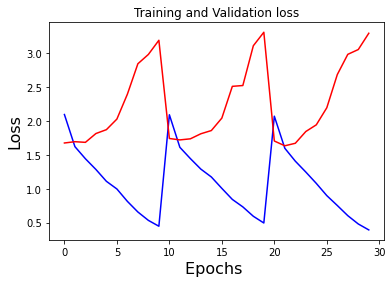

In [23]:
plt.plot(range(len(train_loss)), train_loss, 'b', label='Training loss')
plt.plot(range(len(val_loss)), val_loss, 'r', label='Validation loss')
plt.title('Training and Validation loss')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Loss',fontsize=16)
plt.show()

### Plot jaccard curves

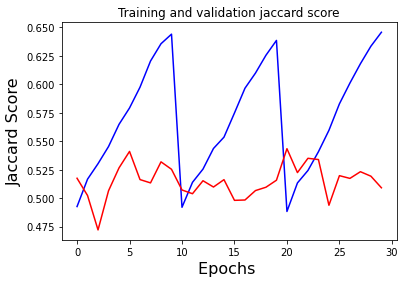

In [24]:
plt.plot(range(len(jac_train)), jac_train, 'b', label='Training jaccard score')
plt.plot(range(len(jac_val)), jac_val, 'r', label='Validation jaccard score')
plt.title('Training and validation jaccard score')
plt.xlabel('Epochs ',fontsize=16)
plt.ylabel('Jaccard Score',fontsize=16)
plt.show()

Similarly, for the test loader:

In [25]:
%%time

t_loader = test_loader(test_df)
predictions = []
models = []
for fold in range(skf.n_splits):
    model = TextModel()
    model.to(device)
    model.load_state_dict(torch.load(f'./bert_fold{fold+1}.pth'))
    model.eval()
    models.append(model)

loader = tqdm(t_loader, total=len(t_loader))
for (idx, data) in enumerate(loader):
    ids = data['ids'].to(device)
    masks = data['masks'].to(device)
    text = data['text']
    offsets = data['offsets'].numpy()

    start_logits = []
    end_logits = []
    for model in models:
        with torch.no_grad():
            output = model(ids, masks)
            start_logits.append(torch.softmax(output[0], dim=1).cpu().detach().numpy())
            end_logits.append(torch.softmax(output[1], dim=1).cpu().detach().numpy())

    start_logits = np.mean(start_logits, axis=0)
    end_logits = np.mean(end_logits, axis=0)
    
    for i, t_data in enumerate(text):
        start_pred = np.argmax(start_logits[i])
        end_pred = np.argmax(end_logits[i])
        if start_pred >= end_pred:
            enc = tokenizer.encode(t_data)
            prediction = tokenizer.decode(enc.ids[start_pred-1:end_pred])
        else:
            prediction = get_selected_text(t_data, start_pred, end_pred, offsets[i])
        predictions.append(prediction)

  0%|          | 0/221 [00:00<?, ?it/s]

CPU times: user 44.4 s, sys: 1.14 s, total: 45.5 s
Wall time: 45.2 s


## Submission

In [26]:
sub_df = pd.read_csv('../input/tweet-sentiment-extraction/sample_submission.csv')
sub_df['selected_text'] = predictions
# post-processing trick
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('!!!!', '!') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('..', '.') if len(x.split())==1 else x)
sub_df['selected_text'] = sub_df['selected_text'].apply(lambda x: x.replace('...', '.') if len(x.split())==1 else x)
sub_df[['textID','selected_text']].to_csv('submission.csv',index=False)
pd.set_option('max_colwidth', 60)

In [27]:
sub_df.sample(25)

,textID,selected_text
1988,faee4563bd,snowbear has finally come out...congrats
1085,0144252776,"and, yes. i <3 mac, if only it weren`t so expensive"
424,0693a85163,this should be boring.
1815,59ee5ff2f9,of
432,d7746b6b68,is listening to p!nk tunage and trying to teach my cat ...
2963,08ad89c6b0,yayy.
2437,a1b12787c2,a rare treat
980,67cafda653,i am public and can`t get anyone to follow me
3012,9f89432794,missing my big girl.
712,c9e5ca399a,i miss you.
